Data Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive

drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Word_Embedding.csv'

data = pd.read_csv(file_path)

df = pd.DataFrame(data)

Mounted at /content/drive


In [2]:
df.head(5)

,Dates,Closed Price,Combined_Desc,Percentage_Change,lemmatized_text,embeddings
0,2010-06-29,1.592667,2013 tesla roadster completely built inhouse t...,NaN,2013 tesla roadster completely built inhouse t...,[0. 0. 0.05688175 0.05730079 0...
1,2010-06-30,1.588667,tesla roadster reaches chinas great wall tesla...,-0.251148,tesla roadster reach china great wall tesla op...,[0. 0. 0.065174 0.08753883 0...
2,2010-07-01,1.464000,tesla roadster gets version 25 upgrade tesla r...,-7.847274,tesla roadster get version 25 upgrade tesla re...,[0. 0. 0. 0. 0...
3,2010-07-02,1.280000,tesla premiers roadster 25 goodwood festival s...,-12.568307,tesla premier roadster 25 goodwood festival sp...,[0. 0. 0. 0. 0...
4,2010-07-06,1.074000,tesla motors faces rough road electriccar busi...,-16.093748,tesla motor face rough road electriccar busine...,[0. 0. 0. 0. 0...


In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval

def convert_str_to_array(embed_str):
    embed_str = embed_str[1:-1]
    str_nums = embed_str.strip().split()
    return np.array([float(num) for num in str_nums if num], dtype=float)

df['embeddings'] = df['embeddings'].apply(convert_str_to_array)



In [4]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Function to create sequences, same as before
def create_sequences(data, sequence_length):
    xs, ys, emb_seqs = [], [], []
    for i in range(sequence_length, len(data)):
        xs.append(data[i-sequence_length:i])
        ys.append(data[i])
    return np.array(xs), np.array(ys)

# # Data preparation
# sequence_length = 5
# embeddings = df['embeddings']
# X, y = create_sequences(df['Percentage_Change'].fillna(0).values, sequence_length)

# # Scale the features
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_scaled = scaler.fit_transform(X)

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled, y, test_size=0.2, random_state=42)

In [5]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Fully connected output layer
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward pass through LSTM layer
        lstm_out, _ = self.lstm(x, (h0, c0))

        # Only take the output from the final time step
        y_pred = self.linear(lstm_out[:, -1, :])
        return y_pred


In [6]:
from sklearn.model_selection import KFold
from itertools import product

def find_parameters_train(X_train, X_test, y_train, y_test, sequence_length):
  # Define hyperparameters to search
  hidden_dims = [50, 100, 150, 200]  # Example hyperparameters
  num_layers_options = [1, 2, 3, 4, 5]
  learning_rates = [0.001, 0.01, 0.1]
  num_epochs = 100
  batch_size = 32

  # Convert the whole training data to PyTorch tensors
  X_train_tensor = torch.tensor(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

  # K-Fold Cross Validation on the training set
  n_splits = 5
  kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

  # Prepare to track the validation loss across folds for each hyperparameter configuration
  results = {}

  # Loop over all possible combinations of hyperparameters
  for hidden_dim, num_layers, lr in product(hidden_dims, num_layers_options, learning_rates):
      fold_val_losses = []  # List to store each fold's validation loss for the current hyperparameter configuration

      for fold, (train_ids, val_ids) in enumerate(kfold.split(X_train_tensor)):
          # Prepare data loaders for the current fold
          X_train_fold = X_train_tensor[train_ids]
          y_train_fold = y_train_tensor[train_ids]
          X_val_fold = X_train_tensor[val_ids]
          y_val_fold = y_train_tensor[val_ids]

          train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=batch_size, shuffle=True)
          val_loader = DataLoader(TensorDataset(X_val_fold, y_val_fold), batch_size=batch_size)


          # Define the LSTM model with the current set of hyperparameters
          model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=1)

          # Define the loss function and optimizer
          criterion = nn.MSELoss()
          optimizer = torch.optim.Adam(model.parameters(), lr=lr)

          # Train the model on the training set of the current fold
          for epoch in range(num_epochs):
              model.train()  # Set the model to training mode
              # Training loop (omitted for brevity)

          # Validate the model on the validation set of the current fold
          model.eval()  # Set the model to evaluation mode
          fold_val_loss = 0.0
          with torch.no_grad():
              for X_batch, y_batch in val_loader:
                  y_pred = model(X_batch)
                  loss = criterion(y_pred, y_batch)
                  fold_val_loss += loss.item()

          fold_val_loss /= len(val_ids)  # Average the loss over the validation set
          fold_val_losses.append(fold_val_loss)  # Store the result

      # Calculate the average validation loss over all folds for the current hyperparameter configuration
      avg_val_loss = np.mean(fold_val_losses)
      results[(hidden_dim, num_layers, lr)] = avg_val_loss
      # print(f"Hidden Dim: {hidden_dim}, Num Layers: {num_layers}, LR: {lr}, Avg Val Loss: {avg_val_loss}")

  # Find the best hyperparameter configuration based on the average validation loss
  best_hyperparams = min(results, key=results.get)
  best_hidden_dim, best_num_layers, best_lr = best_hyperparams
  print(f"Best Hyperparams -> Hidden Dim: {best_hidden_dim}, Num Layers: {best_num_layers}, LR: {best_lr}")

  # Retrain the model on the full training set with the best hyperparameters
  best_model = LSTMModel(input_dim=1, hidden_dim=best_hidden_dim, num_layers=best_num_layers, output_dim=1)
  best_optimizer = torch.optim.Adam(best_model.parameters(), lr=best_lr)

  # Convert the training and testing data to PyTorch tensors
  X_train_tensor = torch.tensor(X_train.reshape(-1, sequence_length, 1), dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

  X_test_tensor = torch.tensor(X_test.reshape(-1, sequence_length, 1), dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

  # Create DataLoader for the training data
  train_data_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

  criterion = nn.MSELoss()

  # Train the model
  num_epochs = 50  # Or any other number of epochs you deem appropriate
  for epoch in range(num_epochs):
      best_model.train()
      for X_batch, y_batch in train_data_loader:
          optimizer.zero_grad()
          y_pred = best_model(X_batch)
          loss = criterion(y_pred, y_batch)
          loss.backward()
          optimizer.step()
      # print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}')

  # Create DataLoader for the testing data
  test_data_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)

  # Switch the model to evaluation mode
  best_model.eval()

  total_loss = 0.0
  count_batches = 0

  # No gradient calculation is needed during evaluation
  with torch.no_grad():
      for X_batch, y_batch in test_data_loader:
          y_pred = best_model(X_batch)
          # Squeeze the predictions to match the target's dimensions

          loss = criterion(y_pred, y_batch)
          total_loss += loss.item()
          count_batches += 1

  # Calculate the average loss over all batches
  average_test_loss = total_loss / count_batches

  return average_test_loss


In [7]:
MSE = []

for i in range(1, 11):
  X, y = create_sequences(df['Percentage_Change'].fillna(0).values, i)
  # Scale the features
  scaler = MinMaxScaler(feature_range=(0, 1))
  X_scaled = scaler.fit_transform(X)

  # Split the data
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
  mse = find_parameters_train(X_train, X_test, y_train, y_test, i)
  MSE.append(mse)
  print(f"sequence length: {i}, mse: {mse}")

print(MSE)

Best Hyperparams -> Hidden Dim: 150, Num Layers: 2, LR: 0.1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

sequence length: 1, mse: 12.410541599447077
Best Hyperparams -> Hidden Dim: 50, Num Layers: 1, LR: 0.001


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

sequence length: 2, mse: 13.903932744806463
Best Hyperparams -> Hidden Dim: 50, Num Layers: 3, LR: 0.01


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

sequence length: 3, mse: 12.944123094732111
Best Hyperparams -> Hidden Dim: 50, Num Layers: 5, LR: 0.1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

sequence length: 4, mse: 12.016738306392323
Best Hyperparams -> Hidden Dim: 100, Num Layers: 2, LR: 0.001


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

sequence length: 5, mse: 14.246330412951382
Best Hyperparams -> Hidden Dim: 100, Num Layers: 4, LR: 0.001


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

sequence length: 6, mse: 11.986624782735651
Best Hyperparams -> Hidden Dim: 50, Num Layers: 5, LR: 0.1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

sequence length: 7, mse: 12.992815505374562
Best Hyperparams -> Hidden Dim: 50, Num Layers: 2, LR: 0.01


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

sequence length: 8, mse: 12.212422782724554
Best Hyperparams -> Hidden Dim: 200, Num Layers: 1, LR: 0.1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

sequence length: 9, mse: 10.93243460221724
Best Hyperparams -> Hidden Dim: 50, Num Layers: 5, LR: 0.01


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


sequence length: 10, mse: 12.041189432144165
[12.410541599447077, 13.903932744806463, 12.944123094732111, 12.016738306392323, 14.246330412951382, 11.986624782735651, 12.992815505374562, 12.212422782724554, 10.93243460221724, 12.041189432144165]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


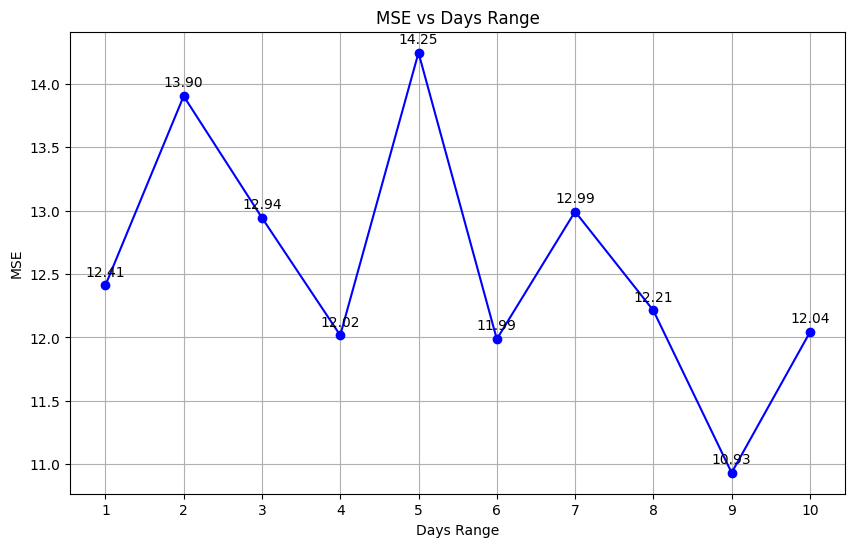

In [9]:
days_range = list(range(1, 11))

plt.figure(figsize = (10, 6))
plt.plot(days_range, MSE, marker = 'o', linestyle = '-', color = 'b')

plt.title('MSE vs Days Range')
plt.xlabel("Days Range")
plt.ylabel("MSE")

plt.xticks(days_range)

for day, mse in zip(days_range, MSE):
    plt.text(day, mse + 0.05, f'{mse:.2f}', ha='center', va='bottom')

plt.grid(True)

plt.show()